# Zillow Data: Predicting Tax Value of Single Family Homes
This is the repo for a regression analysis project using a Zillow data set to assess drivers for tax value of single family homes and also create a predictive ML model for prices.

**Goal:** To use the finished square footage, number of bedrooms and number of bathrooms to estimate the assessed tax value of single family homes that had a transaction in 2017.

**Plan of Attack:**

1. Get background information on the properties in the dataset to include a data dictionary.
2. Use information gleaned to build a MySQL query that efficiently retrieves only the necessary data and import it into a Pandas DataFrame.
3. Wrangle data as necessary to clean, tidy, and split into Train, Validation, and Test datasets for EDA.
4. Apply pre-processing steps such as scaling and encoding to prepare for modeling.
5. Model the data using appropriate regression techniques to predict the continuous target variable.
6. Evaluate metrics from various models and choose a recommended best model.
7. Prepare report of findings
8. Prepare a tidy repo of all instructions and files needed to explain and repeat processes.

### Intro: Background Information

There are three FIPS codes in the dataset. These are Federal Information Processing Codes which are created by the federal government and ANSI to designate specific locations in a standardized way. In this case they are codes for counties in California where all of the properties in the dataset are located. Here they are described in order from Northwest to Southeast:

#### **Counties in the Dataset:**

##### **Ventura County: FIPS 6111**
![Ventura County Map](ventura_county_map.png "Ventura County Map")
Ventura County (/vɛnˈtʊərə/ (listen)) is a county in the southern part of the U.S. state of California. As of the 2020 census, the population was 843,843.[9][11] The largest city is Oxnard, and the county seat is the city of Ventura.[12]

Ventura County comprises the Oxnard–Thousand Oaks–Ventura, CA Metropolitan Statistical Area, which is part of the Greater Los Angeles area (Los Angeles-Long Beach, CA Combined Statistical Area). It is also considered the southernmost county along the California Central Coast.[13]

Two of the Channel Islands are part of the county: Anacapa Island, which is the most visited island in Channel Islands National Park,[14] and San Nicolas Island.
- Wikipedia, *Ventura County, California*

##### **Los Angeles County FIPS 6037**
![LA County Map](la_county_map.png "LA County Map")
Los Angeles County, officially the County of Los Angeles (Spanish: Condado de Los Ángeles),[7] and sometimes abbreviated as L.A. County, is the most populous county in the United States, with 9,861,224 residents estimated in 2022.[1] Its population is greater than that of 40 individual U.S. states. Comprising 88 incorporated cities and many unincorporated areas within a total area of 4,083 square miles (10,570 km2), it is home to more than a quarter of Californians and is one of the most ethnically diverse U.S. counties.[8] The county's seat, Los Angeles, is the second most populous city in the United States, with about 3.9 million residents.
- Wikipedia, *Los Angeles County, California*

##### **Orange County: FIPS 6059**
![Orange County Map](orange_county_map.png "Orange County Map")
Orange County, often known by its initials O.C., is located in the Los Angeles metropolitan area in Southern California. As of the 2020 census, the population was 3,186,989,[4] making it the third-most-populous county in California, the sixth-most-populous in the United States, and more populous than 19 American states and Washington, D.C.[6] Although largely suburban, it is the second-most-densely-populated county in the state behind San Francisco County.[7] The county's three most-populous cities are Anaheim, Santa Ana, and Irvine, each of which has a population exceeding 300,000.[8] Santa Ana is also the county seat. Six cities in Orange County are on the Pacific coast: Seal Beach, Huntington Beach, Newport Beach, Laguna Beach, Dana Point, and San Clemente. Orange County is included in the Los Angeles-Long Beach-Anaheim Metropolitan Statistical Area. The county has 34 incorporated cities.  
- Wikipedia, *Orange County, California*

#### California Property Tax Information
Since we are creating a model of assessed tax value for properties in three California counties, it is useful to have some background on how those values are assessed and levied.

The California Legislative Affairs Office (CLAO) website describes the basics of property taxation in California:
https://lao.ca.gov/reports/2012/tax/property-tax-primer-112912.aspx
> "A Property Tax Bill Includes a Variety of Different Taxes and Charges. A typical California property tax bill consists of many taxes and charges including the 1 percent rate, voter–approved debt rates, parcel taxes, Mello–Roos taxes, and assessments. This report focuses primarily on the 1 percent rate, which is the largest tax on the property tax bill and the only rate that applies uniformly across every locality. The taxes due from the 1 percent rate and voter–approved debt rates are based on a property’s assessed value. The California Constitution sets the process for determining a property’s taxable value. Although there are some exceptions, a property’s assessed value typically is equal to its purchase price adjusted upward each year by 2 percent. Under the Constitution, other taxes and charges may not be based on the property’s value."

> "newer property owners often pay a higher effective tax rate than people who have owned their homes or businesses for a long time." (due to property values growing faster than the two percent mechanism)

![Sample Tax Bill](sample_ca_prop_tax_bill.png "Sample California Property Tax Bill")

For the sample bill above, Section A shows the assessed value of the property, Section B the taxes based on a percentage of taxable value, and section C the taxes levied without regard to the assessed value. The General Tax Levy is state mandated and applies to all properties (there are some exemptions, but they apply to governments, non-profits, religious institutions and seem irrelavent to this project). Each property will likely belong to one or more special districts whose boundaries do not necessarily correspond to the fips code or county that the property is in. This makes prediction of these elements somewhat difficult without mapping all of the properties into their respective special districts. However, there is some general guidance as to the ratio between the General Levy and the average of the other taxes in the CLAO report:

> Local governments collected about 43 billion dollars in 2010–11 from the 1 percent rate. The other taxes and charges on the property tax bill generated an additional 12 billion dollars.

This amount to a split of about 21.8% of tax bill outside of the general levy and 78.2% from the general levy.
Key Takeaways:
1. The *process* for determining property value is mandated by state Constitution
2. It applies universally to every locality in the state.
3. The formula for determining taxable value is *purchase price + 2% per year*
4. The state tax rate is 1%.
5. There can be locality specific taxes as well. 


##### **Data Dictionary:**

area -  Calculated total finished living area of the home in square feet.

assess_year - The year of the property tax assessment. 

bedrooms -  Number of bedrooms in home.

bathrooms -  Number of bathrooms in home including fractional bathrooms.

fips - Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details

zip_mean_tv_2016 - mean tax value by zip code in 2016

tax_amount - The total property tax assessed for that assessment year.

tax_value - The total tax assessed value of the parcel in U.S Dollars. This is the target variable.

tax_rate_2016 - tax value in 2016 divided by tax amount 2016

year_built - The Year the principal residence was built. 

zip - Zip code in which the property is located.



### 1. Initial Questions

What are the generally accepted rules governing real estate prices?

    - location, location, location:
        - schools
        - neighborhood
        - busy street v quiet neighborhood
        - proximity to amenities
        - lot size/shape
        - zoning
    - curb appeal
        - architectural style may be useful if one style is trending
    - home features
        - pool
        - A/C
        - fireplace
        - garage
        - general condition
        
What are the proxies for these things in the dataset?

    - proxies for location
        - county (fips) may play a small role, but it seems way too coarse a measure of location.
        - ZIP code would be much more useful
        - Property tax rates may function as signatures for school districts and neighborhoods because in California there are lots of very local special districts. When looking at tax rates for Property taxes in Ventura County, I found there were 2,493 tax areas in 2017. Many of them had different tax rates associated with area of city and school district.
        - Property tax rates coupled with ZIP code could provide a pretty good fingerprint of neighborhood
    - proxies for curb appeal
        - architectural style
        - overall condition of home


#### Imports

In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from math import sqrt
# to turn off pink warning boxes basically for display purposes in class
import warnings
warnings.filterwarnings('ignore')

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# import tools for scaling
import sklearn.preprocessing

# classification algorithms
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# linear regression algorithms
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# classification analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# feature selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# to see local file system
import os

# import our own modules
import env
import wrangle as w
import prep as p

np.random.seed = 9751

# jupyter settings
%matplotlib inline

### Acquire Clean Data

In [85]:
zillow = w.remove_outliers(w.clean_zillow_data2017())
zillow.head().T

,0,1,2,3,4
bedrooms,4,2,3,4,4
bathrooms,3.5,1.0,2.0,3.0,3.0
area,3100.0,1465.0,1243.0,2376.0,2962.0
year_built,1998,1967,1962,1970,1950
fips,orange_county,ventura_county,orange_county,la_county,la_county
zip,96978,97099,97078,96330,96293
tax_value_2016,1007912.0,452000.0,556295.0,142963.0,761688.0
tax_amount_2016,11013.72,5573.12,6488.3,1777.51,9516.26
tax_value,1023282.0,464000.0,564778.0,145143.0,773303.0
tax_amount,11013.72,5672.48,6488.3,1777.51,9516.26


In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46117 entries, 0 to 46116
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          46117 non-null  int64  
 1   bathrooms         46117 non-null  float64
 2   area              46117 non-null  float64
 3   year_built        46117 non-null  int64  
 4   fips              46117 non-null  object 
 5   zip               46117 non-null  int64  
 6   tax_value_2016    46117 non-null  float64
 7   tax_amount_2016   46117 non-null  float64
 8   tax_value         46117 non-null  float64
 9   tax_amount        46117 non-null  float64
 10  age               46117 non-null  int64  
 11  tax_rate_2016     46117 non-null  float64
 12  zip_mean_tv_2016  46117 non-null  float64
dtypes: float64(8), int64(4), object(1)
memory usage: 4.6+ MB


### Univariate Analysis

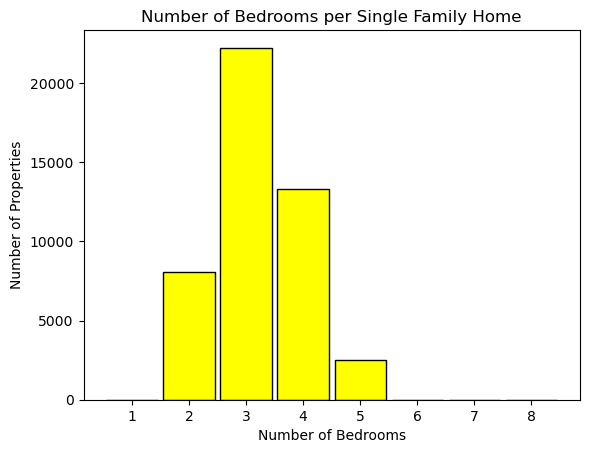


The mean number of bedrooms is 3.22
The median number of bedrooms is 3.0
The mode number of bedrooms is 3
The feature bedrooms has a relatively normal distribution
____________________________________________________________
____________________________________________________________


In [4]:
# Number of Bedrooms

plt.hist(x='bedrooms', data=zillow, bins=range(1,10), 
         rwidth=.9, color='yellow', ec='black', align='left')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Properties')
plt.title('Number of Bedrooms per Single Family Home')
plt.show()
print(f'\nThe mean number of bedrooms is {zillow.bedrooms.mean():.2f}')
print(f'The median number of bedrooms is {zillow.bedrooms.median()}')
print(f'The mode number of bedrooms is {zillow.bedrooms.mode()[0]}')
print('The feature bedrooms has a relatively normal distribution')
print('____________________________________________________________')
print('____________________________________________________________')

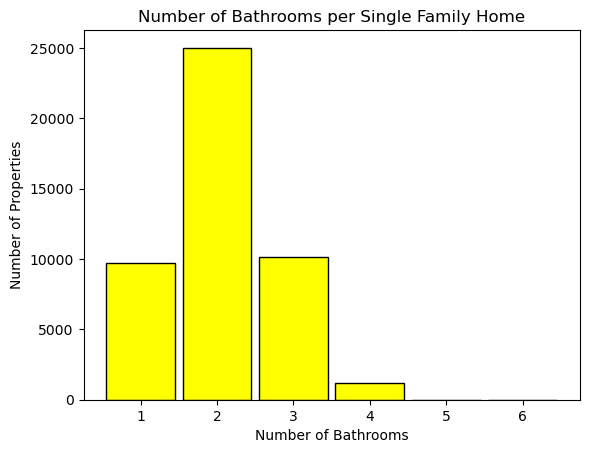


The mean number of bathrooms is 2.12
The median number of bathrooms is 2.0
The mode number of bathrooms is 2.0
The feature bathrooms has a relatively normal distribution
____________________________________________________________
____________________________________________________________


In [5]:
# Number of Bathrooms

plt.hist(x='bathrooms', data=zillow, bins=range(1,8), 
         rwidth=.9, color='yellow', ec='black', align='left')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Number of Properties')
plt.title('Number of Bathrooms per Single Family Home')
plt.show()
print(f'\nThe mean number of bathrooms is {zillow.bathrooms.mean():.2f}')
print(f'The median number of bathrooms is {zillow.bathrooms.median():.1f}')
print(f'The mode number of bathrooms is {zillow.bathrooms.mode()[0]:.1f}')
print('The feature bathrooms has a relatively normal distribution')
print('____________________________________________________________')
print('____________________________________________________________')

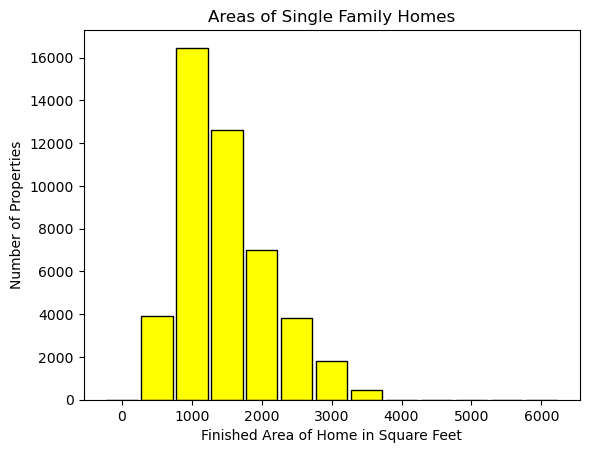


The mean square footage is 1723
The median square footage is 1583
The mode square footage is 1120
The feature area has a relatively normal distribution with right skew
____________________________________________________________
____________________________________________________________


In [6]:
# Area of home in finished square feet

plt.hist(x='area', data=zillow, bins=range(0,7000,500), 
         rwidth=.9, color='yellow', ec='black', align='left')
plt.xlabel('Finished Area of Home in Square Feet')
plt.ylabel('Number of Properties')
plt.title('Areas of Single Family Homes')
plt.show()
print(f'\nThe mean square footage is {zillow.area.mean():.0f}')
print(f'The median square footage is {zillow.area.median():.0f}')
print(f'The mode square footage is {zillow.area.mode()[0]:.0f}')
print('The feature area has a relatively normal distribution with right skew')
print('____________________________________________________________')
print('____________________________________________________________')

- The Tax Values of the properties seem very low to me for the counties and years under consideration. I will add this to the things to look into in the future.

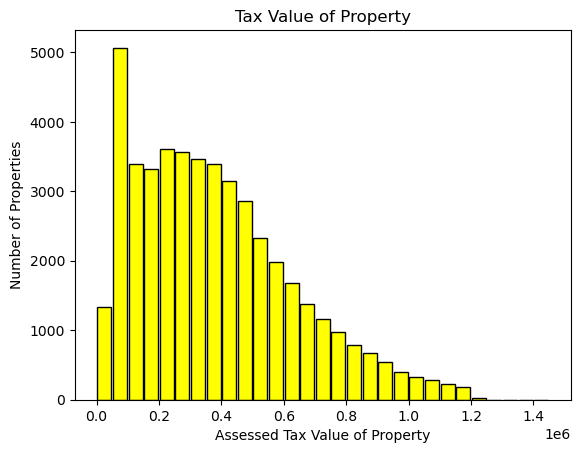


The mean assessed tax value is $379,978
The median assessed tax value is $340,108
The mode assessed tax value is $455,000
The feature tax value has a right-skewed distribution with a
    strong peak in the 50-100k bucket.
____________________________________________________________
____________________________________________________________


In [7]:
# Assessed Tax Value of Home

plt.hist(x='tax_value', data=zillow, bins=range(0,1_500_000, 50_000), 
         rwidth=.9, color='yellow', ec='black', align='mid')
plt.xlabel('Assessed Tax Value of Property')
plt.ylabel('Number of Properties')
plt.title('Tax Value of Property')
plt.show()
print(f'\nThe mean assessed tax value is ${zillow.tax_value.mean():,.0f}')
print(f'The median assessed tax value is ${zillow.tax_value.median():,.0f}')
print(f'The mode assessed tax value is ${zillow.tax_value.mode()[0]:,.0f}')
print('The feature tax value has a right-skewed distribution with a\n\
    strong peak in the 50-100k bucket.')
print('____________________________________________________________')
print('____________________________________________________________')

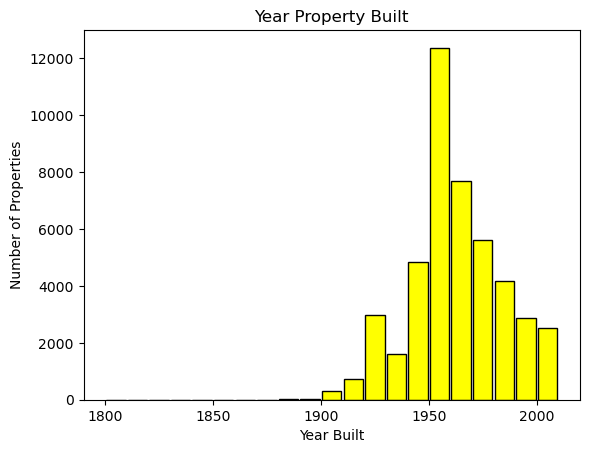


The mean year built is 1962
The median year built is 1960
The mode year built is 1955
The feature year built has a slightly left-skewed distribution with a
    strong peak in the 1950s bucket.
____________________________________________________________
____________________________________________________________


In [8]:
# Year home was built

plt.hist(x='year_built', data=zillow, bins=range(1800,2020,10), 
         rwidth=.9, color='yellow', ec='black', align='mid')
plt.xlabel('Year Built')
plt.ylabel('Number of Properties')
plt.title('Year Property Built')
plt.show()
print(f'\nThe mean year built is {zillow.year_built.mean():.0f}')
print(f'The median year built is {zillow.year_built.median():.0f}')
print(f'The mode year built is {zillow.year_built.mode()[0]:.0f}')
print('The feature year built has a slightly left-skewed distribution with a\n\
    strong peak in the 1950s bucket.')
print('____________________________________________________________')
print('____________________________________________________________')

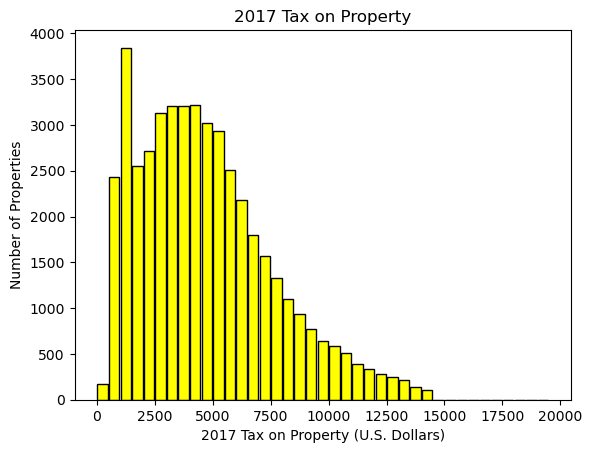


The mean tax is $4,711
The median tax is $4,273
The mode tax is $346
The feature tax amount has a right-skewed distribution with a
    strong peak in the $1500-$2000 bucket.
____________________________________________________________
____________________________________________________________


In [9]:
# Tax Amount of Home

plt.hist(x='tax_amount', data=zillow, bins=range(0,20_000,500), 
         rwidth=.9, color='yellow', ec='black', align='mid')
plt.xlabel('2017 Tax on Property (U.S. Dollars)')
plt.ylabel('Number of Properties')
plt.title('2017 Tax on Property')
plt.show()
print(f'\nThe mean tax is ${zillow.tax_amount.mean():,.0f}')
print(f'The median tax is ${zillow.tax_amount.median():,.0f}')
print(f'The mode tax is ${zillow.tax_amount.mode()[0]:,.0f}')
print('The feature tax amount has a right-skewed distribution with a\n\
    strong peak in the $1500-$2000 bucket.')
print('____________________________________________________________')
print('____________________________________________________________')

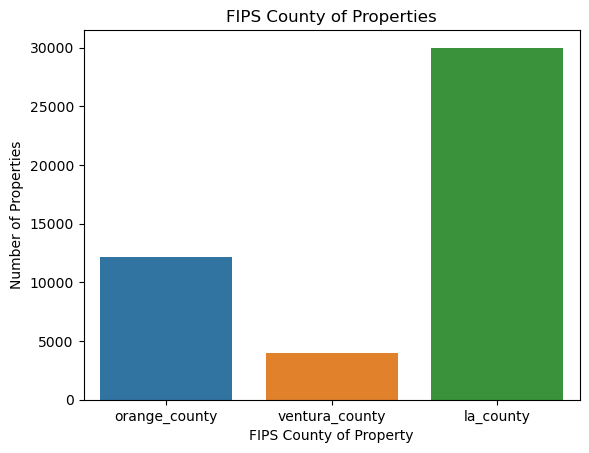

In [10]:
# Assessment of properties by FIPS

sns.countplot(x='fips', data=zillow)
plt.xlabel('FIPS County of Property')
plt.ylabel('Number of Properties')
plt.title('FIPS County of Properties')
plt.show()

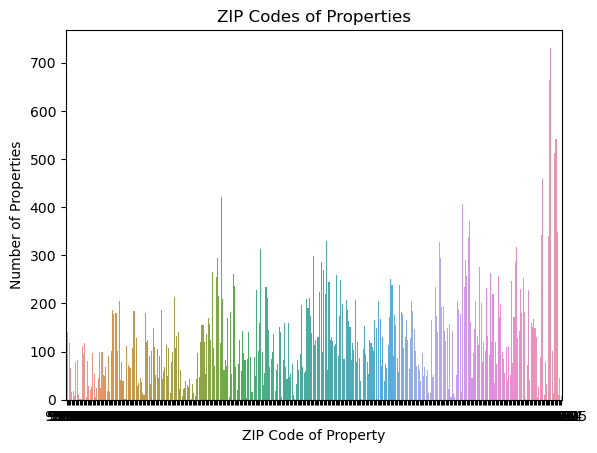

In [11]:
sns.countplot(x='zip', data=zillow)
plt.xlabel('ZIP Code of Property')
plt.ylabel('Number of Properties')
plt.title('ZIP Codes of Properties')
plt.show()

##### Can see there are large disparities in number of properties per ZIP code, ranging from near zero to over 700.

#### Univariate Summary:
**For single-family homes with a transaction in 2017:**

1. average home was built in 1962
2. had 3.22 bedrooms
3. had 2.12 bathrooms
4. was 1725 square feet
5. with a mean tax value of \$381,625
6. and a mean tax amount of \$4,729
7. The majority were in LA County, followed by Orange, then Ventura

- bedrooms, bathrooms, and year built are relatively normally distributed
- finished area is slightly right skewed
- tax value and tax are both right skewed with a strong peak near the lower boundary



### Splitting Dataset

In [12]:
train, val, test = w.wrangle_zillow()

In [13]:
train.shape, val.shape, test.shape

((25825, 13), (11068, 13), (9224, 13))

### Bivariate Analysis

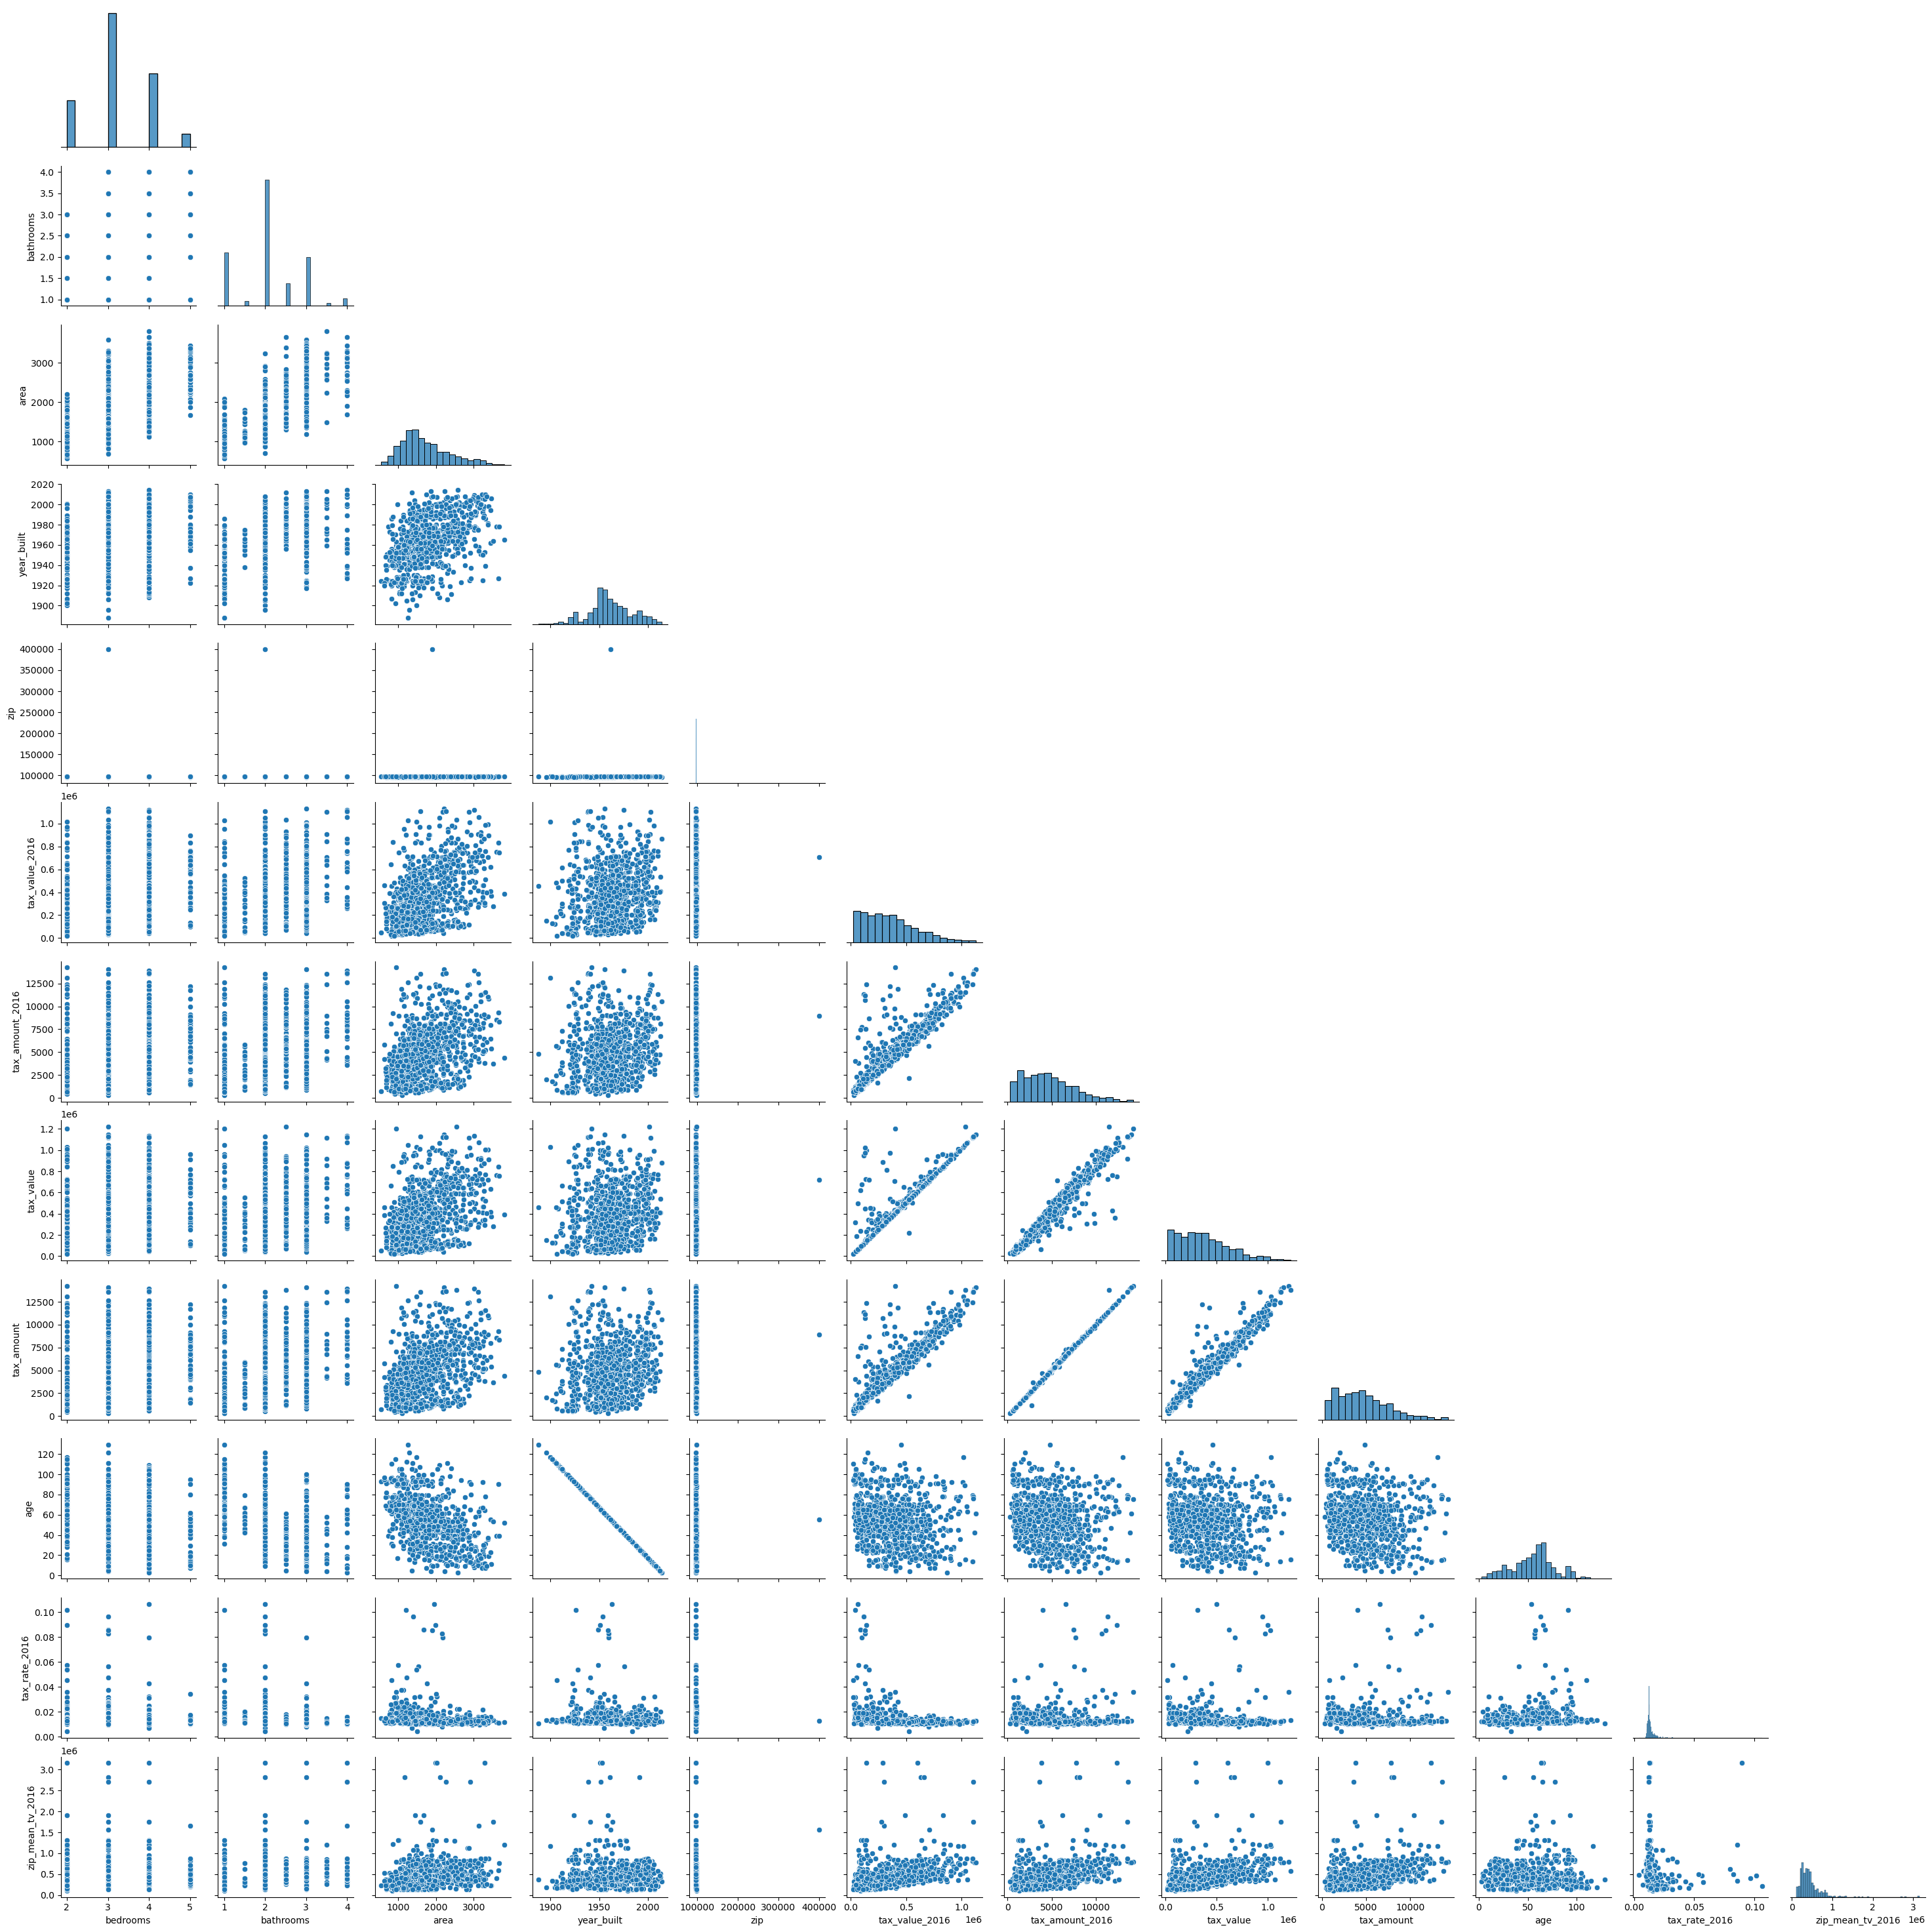

In [84]:
sns.pairplot(train.sample(1000), corner=True)
plt.show()

#### Bivariate Questions:

1. Is there a correlation between the number of bathrooms and the tax value?
2. Is there a correlation between the number of bedrooms and the tax value?
3. Is there a correlation between the area of the house and the tax value?
4. Is there a correlation between FIPS and the tax value of the house?

#### 1. Test correlation between number of bathrooms and tax value

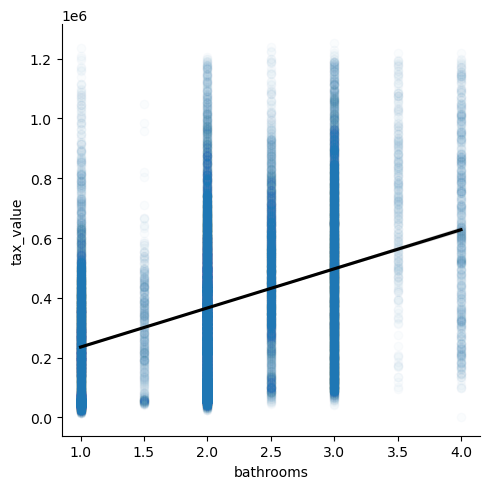

In [15]:
sns.lmplot(x='bathrooms', y='tax_value', data=train, 
           line_kws={'color': 'black'}, scatter_kws={'alpha': 0.02})
plt.show()

In [16]:
# visually it appears there is a correlation
# to confirm, statisically test a hypothesis
# use spearman test due to the ordinal nature
# bathrooms and the non_normality of tax_value.

$H_0:$ There is no linear correlation between bathrooms and tax value

$H_1:$ There is a linear correlation between bathrooms and tax value

In [17]:
# Let's set a 95% confidence level for statistical significance, so
α = 0.05

corr_bath, p_bath = stats.spearmanr(train.bathrooms, train.tax_value)

if p_bath < α:
    print(f'Correlation coefficient: {corr_bath}')
    print(f'p: {p_bath}')
    print('Reject the null hypothesis that there is no linear correlation between bathrooms and tax value')
else:
    print('We cannot reject the null hypothesis that there is no linear correlation between bathrooms and tax value')

Correlation coefficient: 0.3822895158135403
p: 0.0
Reject the null hypothesis that there is no linear correlation between bathrooms and tax value


#### 2. Test correlation between the number of bedrooms and the tax value?


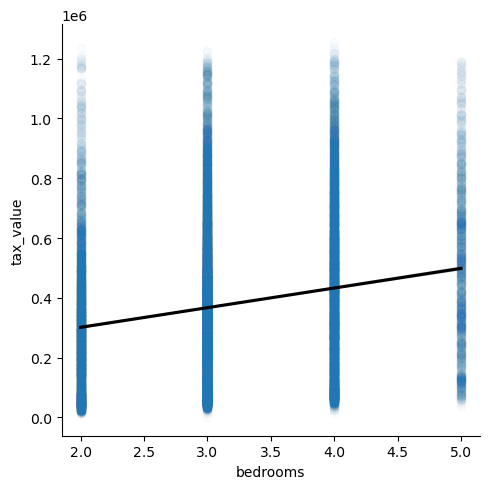

In [18]:
sns.lmplot(x='bedrooms', y='tax_value', data=train, 
           line_kws={'color': 'black'}, scatter_kws={'alpha': 0.02})
plt.show()

In [19]:
# visually it appears there is a correlation
# to confirm, statisically test a hypothesis
# use spearman test due to the ordinal nature
# bedrooms and the non_normality of tax_value.

$H_0:$ There is no linear correlation between bedrooms and tax value

$H_1:$ There is a linear correlation between bedrooms and tax value

In [20]:
# Let's set a 95% confidence level for statistical significance, so
α = 0.05

corr_bed, p_bed = stats.spearmanr(train.bedrooms, train.tax_value)

if p_bath < α:
    print(f'Correlation coefficient: {corr_bed}')
    print(f'p: {p_bath}')
    print('Reject the null hypothesis that there is no linear correlation between bedrooms and tax value')
else:
    print('We cannot reject the null hypothesis that there is no linear correlation between bedrooms and tax value')

Correlation coefficient: 0.20925125469480507
p: 0.0
Reject the null hypothesis that there is no linear correlation between bedrooms and tax value


#### 3. Is there a correlation between the area of the house and the tax value?


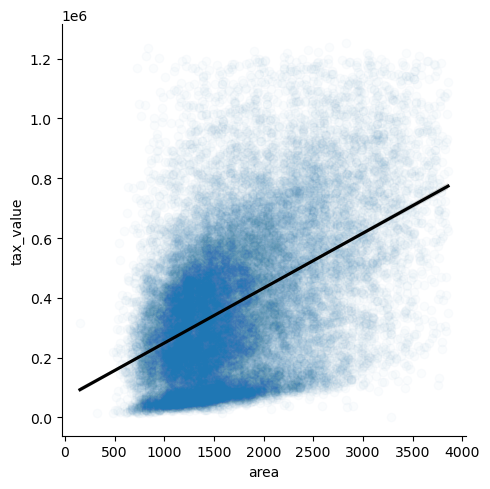

In [21]:
sns.lmplot(x='area', y='tax_value', data=train, 
           line_kws={'color': 'black'}, scatter_kws={'alpha': 0.02})
plt.show()

In [22]:
# visually it appears there is a correlation
# to confirm, statisically test a hypothesis
# use pearson r test as area is relatively normal.

$H_0:$ There is no linear correlation between bedrooms and tax value

$H_1:$ There is a linear correlation between bedrooms and tax value

In [23]:
# Let's set a 95% confidence level for statistical significance, so
α = 0.05

corr_area, p_area = stats.pearsonr(train.area, train.tax_value)

if p_bath < α:
    print(f'Correlation coefficient: {corr_area}')
    print(f'p: {p_area}')
    print('Reject the null hypothesis that there is no linear correlation between area and tax value')
else:
    print('We cannot reject the null hypothesis that there is no linear correlation between area and tax value')

Correlation coefficient: 0.46155576134375303
p: 0.0
Reject the null hypothesis that there is no linear correlation between area and tax value


#### 4. Is there a correlation between FIPS and the tax value of the house?

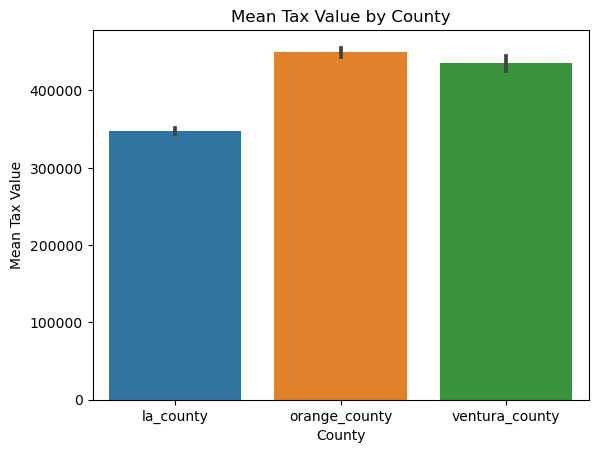

In [24]:
sns.barplot(x='fips', y='tax_value', data=train)
plt.title('Mean Tax Value by County')
plt.xlabel('County')
plt.ylabel('Mean Tax Value')
plt.show()

In [25]:
# It appears there is a correlation between fips and tax_value
# best to check this pairwise for significance with statistical testing
# start with 6037 v 6059, then 6059 v 6111, then 6037 v 6111

In [26]:
train.fips.value_counts(normalize=True).round(3)

la_county         0.654
orange_county     0.262
ventura_county    0.085
Name: fips, dtype: float64

In [27]:
unique_fips = train.fips.unique().tolist()
unique_fips

['la_county', 'orange_county', 'ventura_county']

#### Tax Value by ZIP Code

In [29]:
train.zip.value_counts()

97319    432
97318    379
97328    298
97329    289
96987    233
        ... 
95996      1
95995      1
96038      1
96226      1
96467      1
Name: zip, Length: 376, dtype: int64

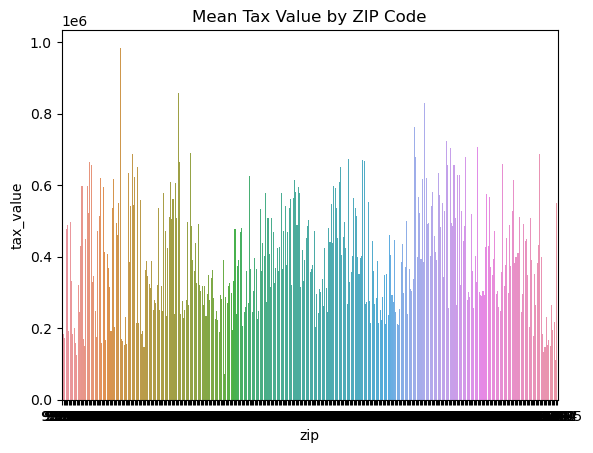

In [30]:
zip_mean_value = train.tax_value.groupby(train.zip
                                        ).agg('mean').sort_values(ascending=False).reset_index()
sns.barplot(x='zip', y='tax_value', data=zip_mean_value)
plt.title('Mean Tax Value by ZIP Code')
plt.show()

In [31]:
zip_tv = train.tax_value.groupby(train.zip
                                        ).agg('mean').round().to_dict()

In [32]:
# need an ordinal column to get the plot I want
zip_mean_value['tax_value_rank'] = range(len(zip_mean_value))
zip_mean_value.head()

,zip,tax_value,tax_value_rank
0,96038,984792.000000,0
1,96128,856795.000000,1
2,96952,830973.571429,2
3,96939,763198.384615,3
4,96975,723370.333333,4


In [33]:
lambda x: zip_tv[x]

<function __main__.<lambda>(x)>

In [34]:
# train['zip_mean_tv'] = train.zip.apply(lambda x: zip_tv[x])
train.sort_values('zip')

,bedrooms,bathrooms,area,year_built,fips,zip,tax_value_2016,tax_amount_2016,tax_value,tax_amount,age,tax_rate_2016,zip_mean_tv_2016
45614,3,2.0,1096.0,1926,la_county,95982,170558.0,3736.87,300000.0,3736.87,91,0.02191,162893.0
11820,3,3.0,912.0,1923,la_county,95982,252000.0,3634.43,266000.0,3634.43,94,0.01442,162893.0
3757,3,2.0,1253.0,1908,la_county,95982,161533.0,2542.36,163995.0,2542.36,109,0.01574,162893.0
36053,2,1.0,552.0,1921,la_county,95982,174200.0,3259.35,228430.0,3259.35,96,0.01871,162893.0
38431,5,3.0,2696.0,1947,la_county,95982,394326.0,6074.89,460314.0,6074.89,70,0.01541,162893.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748,3,4.0,2305.0,1979,la_county,399675,697030.0,8684.32,707659.0,8684.32,38,0.01246,1561326.0
37343,3,2.0,2277.0,1961,la_county,399675,138401.0,2036.80,150916.0,2036.80,56,0.01472,1561326.0
4529,4,3.0,2640.0,1965,la_county,399675,910904.0,11322.38,924794.0,11322.38,52,0.01243,1561326.0
29090,3,2.0,1895.0,1962,la_county,399675,708890.0,8945.78,719700.0,8945.78,55,0.01262,1561326.0


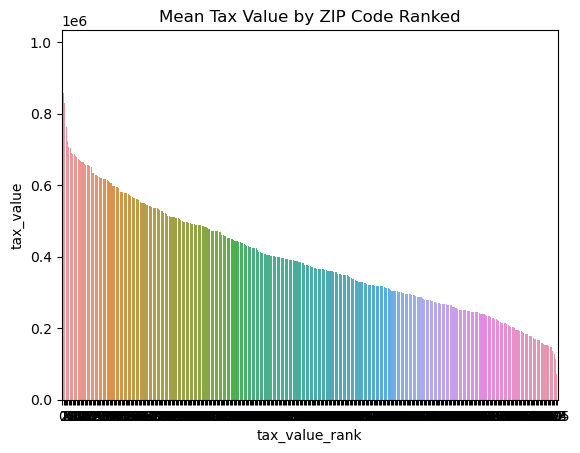

In [35]:
sns.barplot(x='tax_value_rank', y='tax_value', data=zip_mean_value)
plt.title('Mean Tax Value by ZIP Code Ranked')
plt.show()

There is obviously a huge variation in mean tax values based on ZIP code. This is a difficult feature to add directly as one-hot encoding would add 377 features. However, mean tax values for a properties ZIP code could be added as a feature and then scaled.

#### Bivariate Summary:

1. There is a high degree of confidence that there is a linear relationship between:
    a. number of bathrooms and tax value
    b. number of bedrooms and tax value
    c. finished square feet of area and tax value
2. There is a high degree of confidence that there is a corellation between fips code and tax value for all three fips in the dataset.
3. Visually, there is a strong relationship between ZIP Code and tax value.

### Preprocessing

1. Added a feature 'zip_mean_tax_value' for each property's ZIP Code to clean_zillow_2017
    - Base column on tax_value_2016 so not to leak current vals into features.
2. Added feature 'age' to clean_zillow_2017 which starts with the 2017 as 0 year.
3. Encode fips
4. Drop columns not needed for modeling (fips, zip, year_built, tax_amount)
5. Split features from target
2. Scale features

In [36]:
train.head()

,bedrooms,bathrooms,area,year_built,fips,zip,tax_value_2016,tax_amount_2016,tax_value,tax_amount,age,tax_rate_2016,zip_mean_tv_2016
38593,3,2.0,1586.0,1947,la_county,96239,229088.0,2964.35,232581.0,2964.35,70,0.01294,223554.0
36996,3,2.0,1564.0,1988,la_county,97328,114125.0,2240.56,115865.0,2240.56,29,0.01963,144078.0
20680,3,2.0,1828.0,1977,orange_county,96954,409428.0,4281.16,415671.0,4281.16,40,0.01046,748833.0
26075,2,2.0,1472.0,1976,orange_county,96996,226542.0,2346.10,229996.0,2346.10,41,0.01036,478161.0
42330,5,3.0,2107.0,1952,la_county,96508,349726.0,4493.86,355058.0,4493.86,65,0.01285,191412.0


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25825 entries, 38593 to 4924
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          25825 non-null  int64  
 1   bathrooms         25825 non-null  float64
 2   area              25825 non-null  float64
 3   year_built        25825 non-null  int64  
 4   fips              25825 non-null  object 
 5   zip               25825 non-null  int64  
 6   tax_value_2016    25825 non-null  float64
 7   tax_amount_2016   25825 non-null  float64
 8   tax_value         25825 non-null  float64
 9   tax_amount        25825 non-null  float64
 10  age               25825 non-null  int64  
 11  tax_rate_2016     25825 non-null  float64
 12  zip_mean_tv_2016  25825 non-null  float64
dtypes: float64(8), int64(4), object(1)
memory usage: 2.8+ MB


In [38]:
# preprocessing steps except scaling:
    # encoded fips
    # dropped columns=['zip', 'year_built', 'fips', 'tax_amount', 
    # tax_amount_2016]
    # split features from target for each dataset

X_train, y_train = p.prep_train(train)
X_val, y_val = p.prep_val(val)
X_test, y_test = p.prep_test(test)

X_train.head()

,bedrooms,bathrooms,area,tax_value_2016,age,tax_rate_2016,zip_mean_tv_2016,orange_county,ventura_county
38593,3,2.0,1586.0,229088.0,70,0.01294,223554.0,0,0
36996,3,2.0,1564.0,114125.0,29,0.01963,144078.0,0,0
20680,3,2.0,1828.0,409428.0,40,0.01046,748833.0,1,0
26075,2,2.0,1472.0,226542.0,41,0.01036,478161.0,1,0
42330,5,3.0,2107.0,349726.0,65,0.01285,191412.0,0,0


In [39]:
# scaling:
columns_to_scale = ['bedrooms', 'bathrooms', 'area', 
                    'tax_value_2016', 'age', 
                    'tax_rate_2016', 'zip_mean_tv_2016']
columns_to_scale

# train_scaled, val_scaled, test_scaled = p.scale_data(X_train, X_val, X_test, columns_to_scale=columns_to_scale)

['bedrooms',
 'bathrooms',
 'area',
 'tax_value_2016',
 'age',
 'tax_rate_2016',
 'zip_mean_tv_2016']

In [40]:
train_scaled, val_scaled, test_scaled = p.scale_data(X_train, X_val, X_test, columns_to_scale=columns_to_scale)
train_scaled

,bedrooms,bathrooms,area,tax_value_2016,age,tax_rate_2016,zip_mean_tv_2016,orange_county,ventura_county
38593,0.333333,0.333333,0.387045,0.185837,0.496350,0.020539,0.039272,0,0
36996,0.333333,0.333333,0.381107,0.088040,0.197080,0.031549,0.013224,0,0
20680,0.333333,0.333333,0.452362,0.339248,0.277372,0.016458,0.211432,1,0
26075,0.000000,0.333333,0.356275,0.183671,0.284672,0.016293,0.122719,1,0
42330,1.000000,0.666667,0.527665,0.288461,0.459854,0.020391,0.028738,0,0
...,...,...,...,...,...,...,...,...,...
18790,0.666667,0.000000,0.274764,0.024828,0.656934,0.031911,0.167510,0,0
21471,0.333333,0.000000,0.274494,0.020387,0.627737,0.018482,0.087460,0,1
29477,0.000000,0.000000,0.272065,0.029626,0.489051,0.020556,0.048280,0,1
15047,0.333333,0.333333,0.319298,0.241159,0.452555,0.024752,0.074815,0,0


In [41]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25825 entries, 38593 to 4924
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          25825 non-null  float64
 1   bathrooms         25825 non-null  float64
 2   area              25825 non-null  float64
 3   tax_value_2016    25825 non-null  float64
 4   age               25825 non-null  float64
 5   tax_rate_2016     25825 non-null  float64
 6   zip_mean_tv_2016  25825 non-null  float64
 7   orange_county     25825 non-null  uint8  
 8   ventura_county    25825 non-null  uint8  
dtypes: float64(7), uint8(2)
memory usage: 1.6 MB


### Modeling

#### Baseline

##### Establish a baseline model based on mean tax value or median tax value. See which has a lower RMSE.

In [42]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

# 1. Predict tv_pred_mean
tv_pred_mean = y_train.tax_value.mean()
y_train['tv_pred_mean'] = tv_pred_mean
y_val['tv_pred_mean'] = tv_pred_mean

# 2. compute tv_pred_median
tv_pred_median = y_train.tax_value.median()
y_train['tv_pred_median'] = tv_pred_median
y_val['tv_pred_median'] = tv_pred_median

In [43]:
# 3. RMSE of tv_pred_mean
rmse_train_mu = mean_squared_error(y_train.tax_value,
                                y_train.tv_pred_mean) ** .5

rmse_val_mu = mean_squared_error(y_val.tax_value, y_val.tv_pred_mean) ** (0.5)

print(f"""RMSE using Mean
Train/In-Sample: {round(rmse_train_mu, 2)} 
Validate/Out-of-Sample: {round(rmse_val_mu, 2)}""")

RMSE using Mean
Train/In-Sample: 253089.2 
Validate/Out-of-Sample: 254406.35


In [44]:
# 4. RMSE of tv_pred_median
rmse_train_med = mean_squared_error(y_train.tax_value, y_train.tv_pred_median) ** .5
rmse_val_med = mean_squared_error(y_val.tax_value, y_val.tv_pred_median) ** (0.5)

print(f"""RMSE using Median
Train/In-Sample: {round(rmse_train_med, 2)} 
Validate/Out-of-Sample: {round(rmse_val_med, 2)}""")

RMSE using Median
Train/In-Sample: 256115.5 
Validate/Out-of-Sample: 257035.92


In [45]:
# Mean baseline RMSE is lower than median so using mean.
# I will house metrics in a df for comparison

metric_df = pd.DataFrame(data=[
    {'model': 'mean_baseline',
     'RMSE_train': rmse_train_mu,
     'RMSE_val': rmse_val_mu,
     'R2_val': explained_variance_score(y_val.tax_value,
                                             y_val.tv_pred_mean)
    }
]
)

#### Linear Regression (OLS)

##### Make an OLS regression model and use is to make tax value predictions

In [46]:
# MAKE THE THING: create the model object
lm = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tv_pred_lm'] = lm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lm)**(1/2)


In [47]:
# Repeat predict, evaluate for Val

y_val['tv_pred_lm'] = lm.predict(X_val)

rmse_val = mean_squared_error(y_val.tax_value, y_val.tv_pred_lm)**(1/2)

print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_val}
Difference:  {rmse_val - rmse_train}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  57497.54922580739 
Validation/Out-of-Sample: 52906.316160513015
Difference:  -4591.233065294371


In [48]:
#Append to the metric_df

metric_df = metric_df.append(
    {'model': 'OLS Regressor',
     'RMSE_train': rmse_train,
     'RMSE_val': rmse_val,
     'R2_val': explained_variance_score(y_val.tax_value,
                                             y_val.tv_pred_lm)
    }, ignore_index=True)

In [49]:
metric_df

,model,RMSE_train,RMSE_val,R2_val
0,mean_baseline,253089.198756,254406.352430,0.000000
1,OLS Regressor,57497.549226,52906.316161,0.956749


In [50]:
OLSmodel.coef_

array([-1.69181229e+03,  2.85501066e+03,  6.29307753e-02,  1.03879216e+00,
        1.58295605e+02,  4.07690775e+06,  1.19253759e-02,  6.69056836e+03,
        9.44358654e+03])

In [51]:
OLSmodel.intercept_

-71896.65251566144

#### LassoLars

##### Use LassoLars regression model and use to make tax value predictions

In [52]:
# MAKE THE THING: create the model object
lars = LassoLars(alpha=0.01)

#1. FIT THE THING: fit the model to training data
lars.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tv_pred_lars'] = lars.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lars) ** (1/2)

#4. REPEAT STEPS 2-3 for val

y_val['tv_pred_lars'] = lars.predict(X_val)

# evaluate: RMSE
rmse_val = mean_squared_error(y_val.tax_value, y_val.tv_pred_lars) ** (1/2)

print(f"""RMSE for Lasso + Lars
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_val}
Difference:  {rmse_val - rmse_train}""")

RMSE for Lasso + Lars
_____________________
Training/In-Sample: 57497.54958001059, 
Validation/Out-of-Sample:  52906.515567754526
Difference:  -4591.0340122560665


In [53]:
lars.coef_

array([-1.68608101e+03,  2.84930960e+03,  5.87474123e-02,  1.03878869e+00,
        1.58068901e+02,  4.07671161e+06,  1.19264982e-02,  6.68354923e+03,
        9.43276176e+03])

In [54]:
#Append
metric_df = metric_df.append(
    {'model': 'lasso_alpha0.01',
     'RMSE_train': rmse_train,
     'RMSE_val': rmse_val,
     'R2_val': explained_variance_score(y_val.tax_value,
                                             y_val.tv_pred_lars)
    }, ignore_index=True)

In [55]:
# MAKE THE THING: create the model object
lars = LassoLars(alpha=0.05)

#1. FIT THE THING: fit the model to training data
lars.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tv_pred_lars'] = lars.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lars) ** (1/2)

#4. REPEAT STEPS 2-3 for val

y_val['tv_pred_lars'] = lars.predict(X_val)

# evaluate: RMSE
rmse_val = mean_squared_error(y_val.tax_value, y_val.tv_pred_lars) ** (1/2)

print(f"""RMSE for Lasso + Lars
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_val}
Difference:  {rmse_val - rmse_train}""")

RMSE for Lasso + Lars
_____________________
Training/In-Sample: 57497.558080887065, 
Validation/Out-of-Sample:  52907.320738167866
Difference:  -4590.2373427192


In [56]:
#Append
metric_df = metric_df.append(
    {'model': 'lasso_alpha0.05',
     'RMSE_train': rmse_train,
     'RMSE_val': rmse_val,
     'R2_val': explained_variance_score(y_val.tax_value,
                                             y_val.tv_pred_lars)
    }, ignore_index=True)

#### Tweedie Regressor (GLM) w/ Poisson

In [57]:
# MAKE THE THING: create the model object
glm = TweedieRegressor(power=1, alpha=0)

#1. FIT THE THING: fit the model to training data
glm.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tv_pred_glm'] = glm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_glm) ** (1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_val['tv_pred_glm'] = glm.predict(X_val)

# evaluate: RMSE
rmse_val = mean_squared_error(y_val.tax_value, y_val.tv_pred_glm) ** (1/2)\

print(f"""RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_val}
Difference:  {rmse_val - rmse_train}""")

RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: 253089.19875588253, 
Validation/Out-of-Sample:  254406.35242977008
Difference:  1317.1536738875438


In [58]:
#Append
metric_df = metric_df.append({
    'model': 'glm_poisson', 
    'RMSE_train': rmse_train,
    'RMSE_val': rmse_val,
    'R2_val':explained_variance_score(y_val.tax_value,
                                           y_val.tv_pred_glm)
    }, ignore_index=True)

#### Tweedie Regressor (GLM) with Normal

In [59]:
# MAKE THE THING: create the model object
glm = TweedieRegressor(power=0, alpha=0)

#1. FIT THE THING: fit the model to training data
glm.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tv_pred_glm'] = glm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_glm) ** (1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_val['tv_pred_glm'] = glm.predict(X_val)

# evaluate: RMSE
rmse_val = mean_squared_error(y_val.tax_value, y_val.tv_pred_glm) ** (1/2)\

print(f"""RMSE for GLM using Tweedie, power=0 & alpha=0
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_val}
Difference:  {rmse_val - rmse_train}""")

RMSE for GLM using Tweedie, power=0 & alpha=0
_____________________
Training/In-Sample: 90478.20668798665, 
Validation/Out-of-Sample:  88177.111061077
Difference:  -2301.0956269096496


In [60]:
#Append
metric_df = metric_df.append({
    'model': 'glm_normal', 
    'RMSE_train': rmse_train,
    'RMSE_val': rmse_val,
    'R2_val':explained_variance_score(y_val.tax_value,
                                           y_val.tv_pred_glm)
    }, ignore_index=True)

#### Polynomial Features

##### Use polynomial features to check for polynomial fit

In [61]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2) #quadratic aka x-squared

#1. Fit and transform X_train_scaled
train_degree2 = pf.fit_transform(train_scaled)

#1. Transform validate_scaled & test_scaled 
val_degree2 = pf.fit_transform(val_scaled)
test_degree2 = pf.fit_transform(test_scaled)


In [62]:
#2.1 MAKE THE THING: create the model object
lm2 = LinearRegression()

#2.2 FIT THE THING: to our data
lm2.fit(train_degree2, y_train.tax_value)

#3. USE THE THING: predict train
y_train['tv_pred_lm2'] = lm2.predict(train_degree2)

#4. Evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lm2) ** (1/2)

#4. REPEAT STEPS 3-4

# predict validate
y_val['tv_pred_lm2'] = lm2.predict(val_degree2)

# evaluate: rmse
rmse_val = mean_squared_error(y_val.tax_value, y_val.tv_pred_lm2) ** 0.5

print(f"""RMSE for Polynomial Model, degrees=2
_____________________________________________
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample:  {rmse_val}
Difference:  {rmse_val - rmse_train}""")

RMSE for Polynomial Model, degrees=2
_____________________________________________
Training/In-Sample:  42201.099658980595 
Validation/Out-of-Sample:  37717.05545806083
Difference:  -4484.044200919765


In [63]:
#Append
metric_df = metric_df.append({
    'model': 'quadratic', 
    'RMSE_train': rmse_train,
    'RMSE_val': rmse_val,
    'R2_val':explained_variance_score(y_val.tax_value,
                                           y_val.tv_pred_lm2)
    }, ignore_index=True)

In [64]:
metric_df

,model,RMSE_train,RMSE_val,R2_val
0,mean_baseline,253089.198756,254406.352430,0.000000e+00
1,OLS Regressor,57497.549226,52906.316161,9.567491e-01
2,lasso_alpha0.01,57497.549580,52906.515568,9.567488e-01
3,lasso_alpha0.05,57497.558081,52907.320738,9.567475e-01
4,glm_poisson,253089.198756,254406.352430,1.110223e-16
5,glm_normal,90478.206688,88177.111061,8.808697e-01
6,quadratic,42201.099659,37717.055458,9.780206e-01


##### my best performing models seem to be the quadratic followed by the OLS regressor. I will plot them against in-sample actuals to get a visual feel of fit.

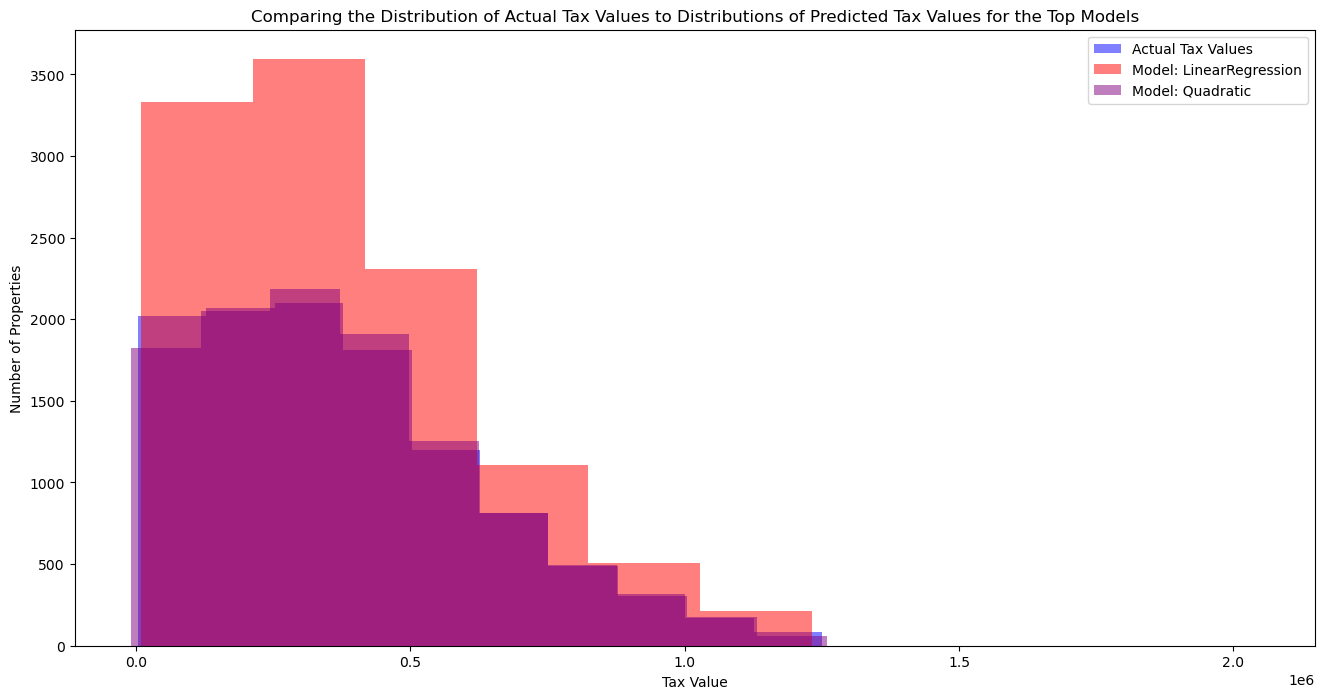

In [65]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_val.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_val.tv_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_val.tv_pred_lm2, color='purple', alpha=.5, label="Model: Quadratic")

plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

#### Revisit Features

In [66]:
# Use K-best selector to see which features have strongest correlation:

# parameters: f_regression stats test, give me 5 features
f_selector = SelectKBest(f_regression, k=1)

# find the top 5 X's correlated with y
f_selector.fit(train_scaled, y_train.tax_value)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature

['tax_value_2016']

In [67]:
# after results from K-best, going to try just the top feature in an OLS model

In [68]:
lm3 = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm3.fit(train_scaled[['tax_value_2016']], y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tv_pred_lm3'] = lm3.predict(train_scaled[['tax_value_2016']])

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lm)**(1/2)



In [69]:
# Repeat 2,3 for val

#2. USE THE THING: make a prediction
y_val['tv_pred_lm3'] = lm3.predict(val_scaled[['tax_value_2016']])

#3. Evaluate: RMSE
rmse_val = mean_squared_error(y_val.tax_value, y_val.tv_pred_lm)**(1/2)

In [70]:
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_val}
Difference:  {rmse_val - rmse_train}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  57497.54922580739 
Validation/Out-of-Sample: 52906.316160513015
Difference:  -4591.233065294371


In [71]:
#Append
metric_df = metric_df.append({
    'model': 'tv_2016_OLS', 
    'RMSE_train': rmse_train,
    'RMSE_val': rmse_val,
    'R2_val':explained_variance_score(y_val.tax_value,
                                           y_val.tv_pred_lm3)
    }, ignore_index=True)

In [72]:
metric_df

,model,RMSE_train,RMSE_val,R2_val
0,mean_baseline,253089.198756,254406.352430,0.000000e+00
1,OLS Regressor,57497.549226,52906.316161,9.567491e-01
2,lasso_alpha0.01,57497.549580,52906.515568,9.567488e-01
3,lasso_alpha0.05,57497.558081,52907.320738,9.567475e-01
4,glm_poisson,253089.198756,254406.352430,1.110223e-16
5,glm_normal,90478.206688,88177.111061,8.808697e-01
6,quadratic,42201.099659,37717.055458,9.780206e-01
7,tv_2016_OLS,57497.549226,52906.316161,9.197992e-01


### Model Selection & Out-of-Sample Evaluation

Model selected: Quadratic (lm3)

In [76]:
# Convert y_test Series to a df
y_test = pd.DataFrame(y_test)

# USE THE THING: predict on test
y_test['tv_pred_quad']=lm2.predict(test_degree2)

# Evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tv_pred_quad)**.5


print(f"""RMSE for Quadratic (lm2)
_____________________________________________      
Out-of-Sample Performance: {rmse_test}
Baseline: {metric_df.RMSE_train[0]}""")

RMSE for Quadratic (lm2)
_____________________________________________      
Out-of-Sample Performance: 45872.18555125383
Baseline: 253089.19875588253


In [77]:
y_train.max()

tax_value         1.253000e+06
tv_pred_mean      3.814907e+05
tv_pred_median    3.422350e+05
tv_pred_lm        2.423587e+06
tv_pred_lars      2.423068e+06
tv_pred_glm       1.290608e+06
tv_pred_lm2       1.402805e+06
tv_pred_lm3       1.204516e+06
dtype: float64

In [82]:
metric_df_test = pd.DataFrame(data=[{
    'model': 'Quadratic', 
    'RMSE': rmse_test,
    'R2_test':explained_variance_score(y_test.tax_value,
                                           y_test.tv_pred_quad)
    }])

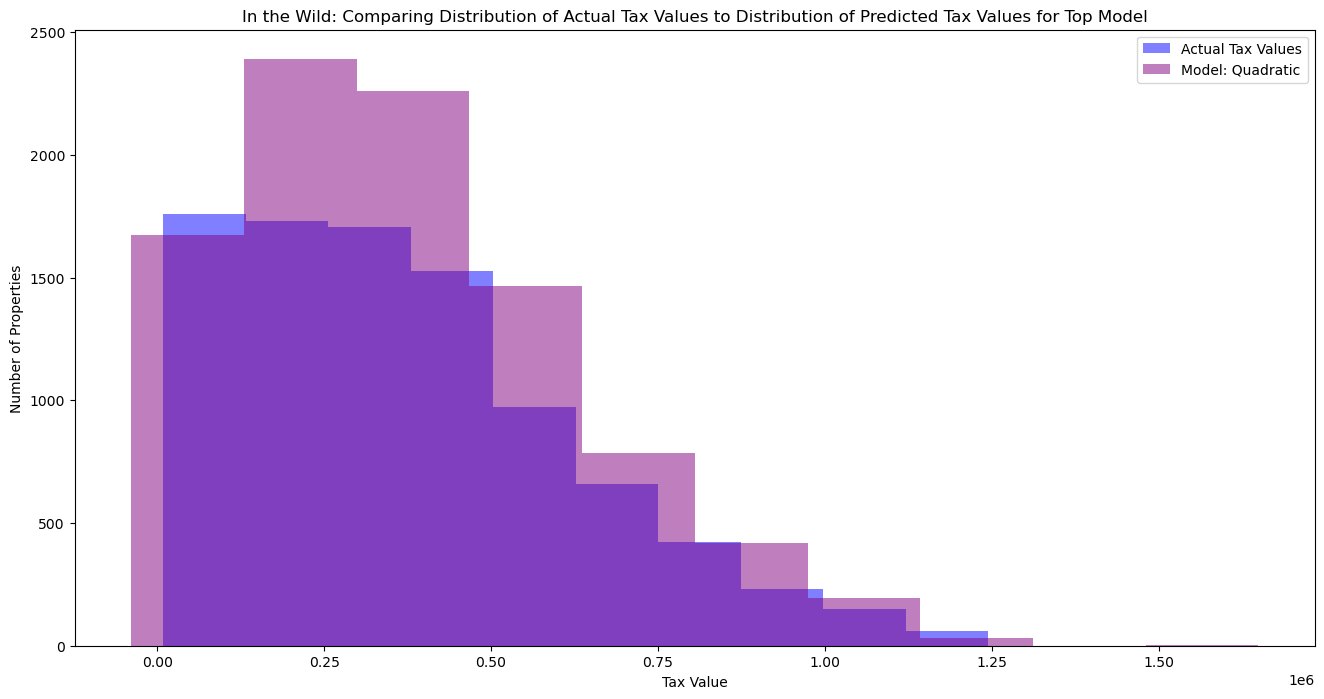

In [83]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_test.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_test.tv_pred_quad, color='purple', alpha=.5, label="Model: Quadratic")

plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.title("In the Wild: Comparing Distribution of Actual Tax Values to Distribution of Predicted Tax Values for Top Model")
plt.legend()
plt.show()

### Model Evaluation

    - Model performance was far better than baseline, but dropped off from validation set.

### Conclusions

    - Final model performance was far better than baseline, but there is still room for more feature engineering and hyperparameter tuning.

### Next Steps

- The Tax Values of the properties seem very low to me for the counties and years under consideration. I will add this to the things to look into in the future.

- Improve hyperparameter tuning.

- Improve Feature Selection